In [53]:
# Default locations if parameter not passed
benchmark_data_path = "tb-compare.pkl"

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from rich import print as rprint
import seaborn as sns
import os
import re
from scipy.stats import bootstrap

benchmark_data = pickle.load(open(benchmark_data_path, "rb"))

df = pd.DataFrame(benchmark_data["dataframe"])

sns.set_theme()

In [55]:
bench_names = df["name"].unique()
print(f"Benchmarks found: {bench_names}")
run_metadata = benchmark_data["config"].applications
n_runs = benchmark_data["config"].metadata.runs

df_bench = df[df["name"] == 'tb-compare']


n_runs = benchmark_data["config"].metadata.runs
print(f"Number of runs: {n_runs}")
print(df_bench.columns)
print(df_bench.head())


Benchmarks found: ['tb-compare']
Number of runs: 2
Index(['name', 'full_output', 'tb_path', 'hosts', 'ompc_tb_iter_num', 'image',
       'type', 'iter', 'node_count', 'time'],
      dtype='object')
         name                                        full_output  \
0  tb-compare  [1749753550.674741] [sorgan-cpu1:417424:0]    ...   
1  tb-compare  [1749753551.241728] [sorgan-cpu1:417539:0]    ...   
2  tb-compare  [1749753551.785171] [sorgan-cpu1:417655:0]    ...   
3  tb-compare  [1749753552.351078] [sorgan-cpu1:417775:0]    ...   
4  tb-compare  [1749753552.903408] [sorgan-cpu1:417890:0]    ...   

        tb_path                                            hosts  \
0  tb-main-loop  sorgan-cpu1,sorgan-cpu2,sorgan-cpu3,sorgan-cpu4   
1  tb-main-loop  sorgan-cpu1,sorgan-cpu2,sorgan-cpu3,sorgan-cpu4   
2  tb-main-loop  sorgan-cpu1,sorgan-cpu2,sorgan-cpu3,sorgan-cpu4   
3  tb-main-loop  sorgan-cpu1,sorgan-cpu2,sorgan-cpu3,sorgan-cpu4   
4  tb-main-loop  sorgan-cpu1,sorgan-cpu2,sorgan-cpu3,

In [56]:
# print the field full_output of the first row
print("Full output of the first row:")

# tb_time field (seconds)
# get total time from the output
def extract_elapsed_time(text):
    matches = re.findall(r"Elapsed Time ([\d.eE+-]+) seconds", text)
    if matches:
        # gets last mach
        # float() already handles scientific notation
        return float(matches[-1])
    return float('nan')

def extract_total_sched_time(text):
    # Find all "Scheduling : <number>"
    matches = re.findall(r"Scheduling\s*:\s*(\d+)", text)
    if not matches:
        print("No scheduling time found in the text.")
        print(text)
        return None
    total_microseconds = sum(int(m) for m in matches)
    return total_microseconds
    # return total_microseconds / 1e6  # microseconds to seconds

def map_schedueler_name(image_name):
    if "improv" in image_name:
        return "Record Replay"
    return "Baseline"

df_bench['tb_time'] = df_bench['full_output'].apply(extract_elapsed_time)
df_bench['sched_time'] = df_bench['full_output'].apply(extract_total_sched_time)
# worker nodes is node_count - 1
df_bench['worker_nodes'] = df_bench['node_count'].apply(lambda x: int(x - 1) if x > 1 else None)
df_bench['scheduler_name'] = df_bench['image'].apply(map_schedueler_name)

print(df_bench.columns)



Full output of the first row:
No scheduling time found in the text.
[1749753550.674741] [sorgan-cpu1:417424:0]        ib_verbs.h:87   UCX  ERROR ibv_exp_query_device(mlx5_0) returned 95: Operation not supported
Running Task Benchmark
  Configuration:
    Task Graph 1:
      Time Steps: 16
      Max Width: 16
      Dependence Type: fft
      Radix: 3
      Period: 0
      Fraction Connected: 0.250000
      Kernel:
        Type: compute_bound
        Iterations: 1000
        Samples: 16
        Imbalance: 0.000000
      Output Bytes: 16
      Scratch Bytes: 0
Loop 0 : Elapsed time : 0.009127
Loop 1 : Elapsed time : 0.005637
Loop 2 : Elapsed time : 0.005529
Loop 3 : Elapsed time : 0.005480
Loop 4 : Elapsed time : 0.005486
Loop 5 : Elapsed time : 0.005576
Loop 6 : Elapsed time : 0.005693
Loop 7 : Elapsed time : 0.005755
Loop 8 : Elapsed time : 0.005737
Loop 9 : Elapsed time : 0.005783
Total Tasks 256
Total Dependencies 648
Total FLOPs 32784384
Total Bytes 0
Elapsed Time 6.543899e-02 second

# Experiment 1

freeze, for now:
kernel: compute_bound
type: fft

freeze:
ompc_tb_iter_num: 100
ompc_init_iter: 5
ompc_resch_iter: 0

y axsis: tb_time
x axis: worker node count 

one line per iter

Processing iteration: 1000
Processing type: fft


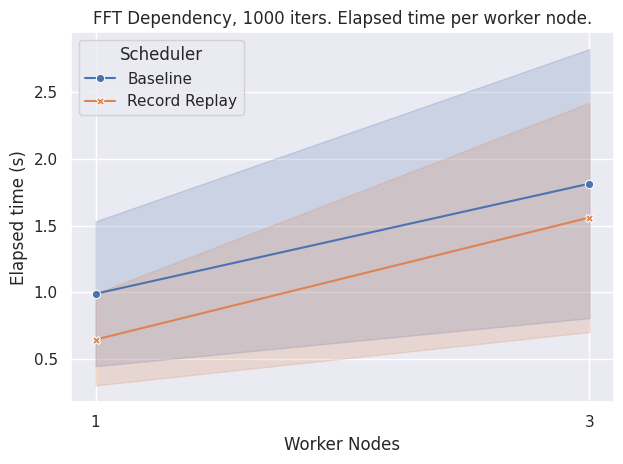

Processing iteration: 10000
Processing type: fft


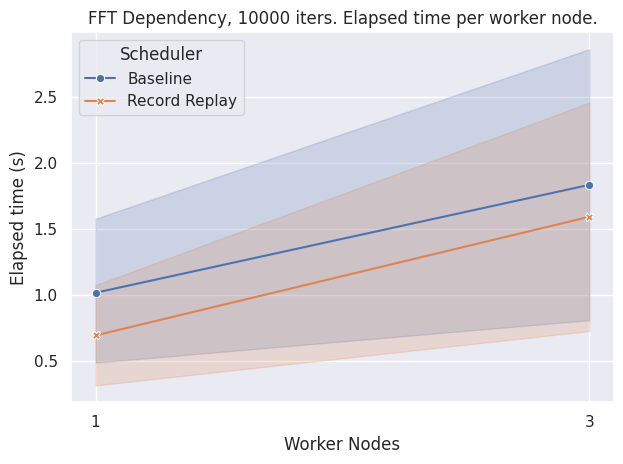

Processing iteration: 1000000
Processing type: fft


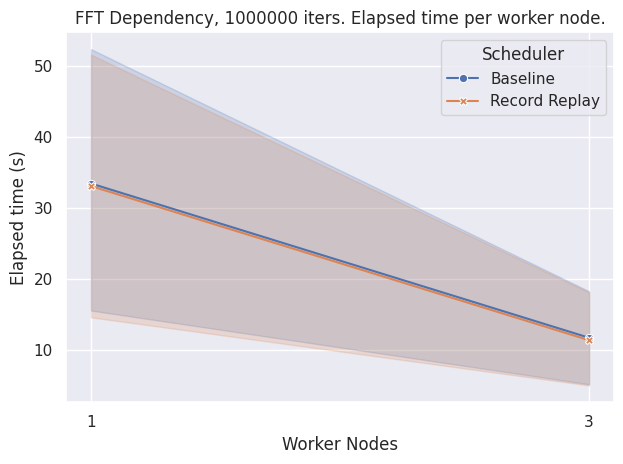

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

for iter in df_bench['iter'].unique():
  print(f"Processing iteration: {iter}")
  for type in df_bench['type'].unique():
    print(f"Processing type: {type}")
    ## TODO: keep doing this for kernel and ompc_tb_iter_num

    # apply filter for this loop
    df_plot = df_bench[(df_bench['iter'] == iter) & (df_bench['type'] == type)].copy()
    df_plot = df_plot[['tb_time', 'worker_nodes', 'scheduler_name']].copy()
    df_plot = df_plot.dropna() # worker nodes can be None if np = 1

    # 2) draw the plot
    plt.figure()
    sns.lineplot(
        data=df_plot,
        x='worker_nodes',
        y='tb_time',
        hue='scheduler_name',
        style='scheduler_name',
        markers=True,
        dashes=False,
        errorbar='ci'
    )

    plt.xlabel('Worker Nodes')
    plt.ylabel('Elapsed time (s)')
    plt.title(f'{type.upper()} Dependency, {iter} iters. Elapsed time per worker node.')
    plt.xticks(sorted(df_plot['worker_nodes'].unique()))
    plt.legend(title='Scheduler')
    plt.grid(True)
    plt.tight_layout()
    plt.show()